In [1]:
from itertools import permutations

import numpy as np
from scipy.stats import dirichlet, multinomial, norm, gamma
import pandas as pd
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns


plt.style.use('blackontrans')


def log5(mu, *args):
    mu0 = mu / (1 - mu)
    p0 = args[0] / (1 - args[0]) / mu0 ** (len(args) - 1)
    for arg in args[1:]:
        p0 *= arg / (1 - arg)
    p = p0 / (p0 + 1)
    return p / np.sum(p)

In [2]:
class Model:
    mu = np.array([0.55, 0.05, 0.25, 0.15])
    alpha0_hc = 100000
    mu_hc_adj = np.array([-0.01, 0.004, 0.003, 0.003])
    alpha_hc = (mu + mu_hc_adj) * alpha0_hc
    mu_home_off = dirichlet.rvs(alpha_hc).reshape(-1)
    mu_home_def = 2 * mu - mu_home_off
    n_teams = 32
    alpha0_off_mu = 1000
    alpha0_off_s2 = 300 ** 2
    alpha0_off = gamma.rvs(a=alpha0_off_mu ** 2 / alpha0_off_s2, scale=alpha0_off_s2 / alpha0_off_mu)
    alpha0_def_mu = 2000
    alpha0_def_s2 = 500 ** 2
    alpha0_def = gamma.rvs(a=alpha0_def_mu ** 2 / alpha0_def_s2, scale=alpha0_def_s2 / alpha0_def_mu)
    alpha_off = mu * alpha0_off
    alpha_def = mu * alpha0_def

    teams_off = dirichlet.rvs(alpha_off, n_teams)
    teams_def = dirichlet.rvs(alpha_def, n_teams)

    games_betw_teams = 4  # must be even
    poss_per_game = norm(100, 5)

In [3]:
def simulate(model):
    rows = []

    teams = enumerate(zip(model.teams_off, model.teams_def))
    for (home_ind, (home_off, home_def)), (away_ind, (away_off, away_def)) in permutations(teams, 2):
        for _ in range(model.games_betw_teams // 2):
            poss = int(model.poss_per_game.rvs())
            home_poss_results = multinomial.rvs(poss, log5(model.mu, home_off, away_def, model.mu_home_off))
            row = {
                'offense_ind': home_ind,
                'defense_ind': away_ind,
                'off_is_home': True,
                'poss': poss,
                'result': home_poss_results
            }
            rows.append(row)
            away_poss_results = multinomial.rvs(poss, log5(model.mu, away_off, home_def, model.mu_home_def))
            row = {
                'offense_ind': away_ind,
                'defense_ind': home_ind,
                'off_is_home': False,
                'poss': poss,
                'result': away_poss_results
            }
            rows.append(row)

    return pd.DataFrame(rows)

results = simulate(Model)

In [ ]:
class Inf:

    mu_exp = results['result'].sum() / results['poss'].sum()
    hc_index = (~results['off_is_home']).values.astype(int)
    
    with pm.Model() as model:
        alpha0_off = pm.Gamma('alpha0_off', mu=Model.alpha0_off_mu, sigma=Model.alpha0_off_s2)
        alpha0_def = pm.Gamma('alpha0_def', mu=Model.alpha0_def_mu, sigma=Model.alpha0_def_s2)
        alpha_off = mu_exp * alpha0_off
        alpha_def = mu_exp * alpha0_def
        teams_off = pm.Dirichlet('team_off', alpha_off, shape=(Model.n_teams, 4))
        teams_def = pm.Dirichlet('team_def', alpha_def, shape=(Model.n_teams, 4))
        hc_off = pm.Dirichlet('hc_off', Model.alpha_hc)
        hc_def = 2 * mu_exp - hc_off
        mu0_exp = mu_exp / (1 - mu_exp)
        offense = teams_off[results['offense_ind'].values]
        defense = teams_def[results['defense_ind'].values]
        home_court = pm.math.stack((hc_off, hc_def))[hc_index]
        p0 = offense / (1 - offense) * defense / (1 - defense) * home_court / (1 - home_court) / mu0_exp ** 2
        p = p0 / (p0 + 1)
        pm.Multinomial('game_result', n=results['poss'].values, p=p, observed=np.vstack(results['result']))

In [4]:
class Inf:

    mu_exp = results['result'].sum() / results['poss'].sum()
    hc_index = (~results['off_is_home']).values.astype(int)
    
    with pm.Model() as model:
        alpha0_off = pm.Gamma('alpha0_off', mu=Model.alpha0_off_mu, sigma=Model.alpha0_off_s2)
        alpha0_def = pm.Gamma('alpha0_def', mu=Model.alpha0_def_mu, sigma=Model.alpha0_def_s2)
        alpha_off = mu_exp * alpha0_off
        alpha_def = mu_exp * alpha0_def
        teams_off = pm.Dirichlet('team_off', alpha_off, shape=(Model.n_teams, 4))
        teams_def = pm.Dirichlet('team_def', alpha_def, shape=(Model.n_teams, 4))
        hc_off = pm.Dirichlet('hc_off', Model.alpha_hc)
        hc_def = 2 * mu_exp - hc_off
        mu0_exp = mu_exp / (1 - mu_exp)
        offense = teams_off[results['offense_ind'].values]
        defense = teams_def[results['defense_ind'].values]
        home_court = pm.math.stack((hc_off, hc_def))[hc_index]
        p0 = offense / (1 - offense) * defense / (1 - defense) * home_court / (1 - home_court) / mu0_exp ** 2
        p = p0 / (p0 + 1)
        pm.Multinomial('game_result', n=results['poss'].values, p=p, observed=np.vstack(results['result']))

In [5]:
with Inf.model:
    trace = pm.sample(2000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hc_off, team_def, team_off, alpha0_def, alpha0_off]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 100 seconds.


/home/matt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/home/matt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.canvas.print_figure(bytes_io, **kw)


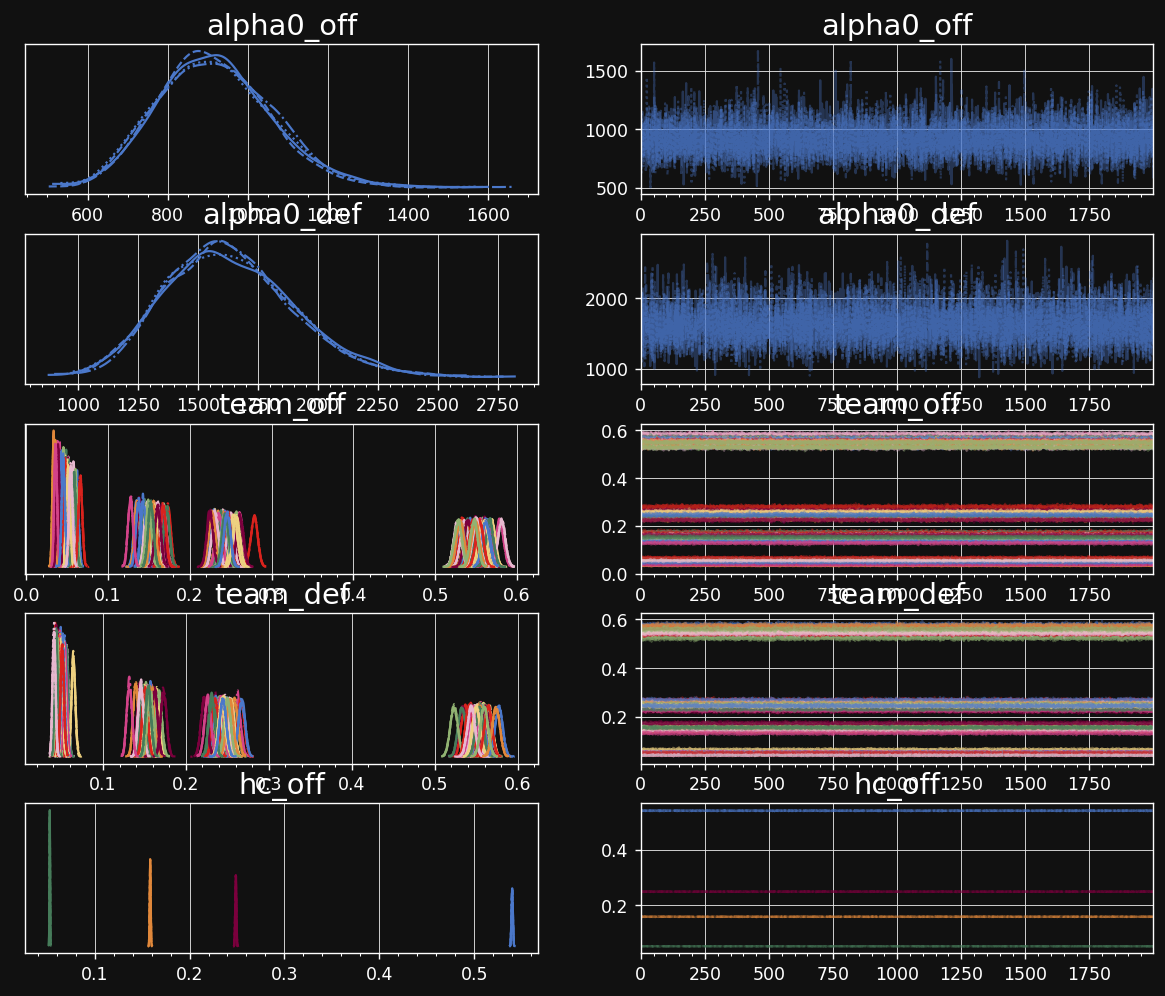

In [6]:
pm.traceplot(trace);

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/home/matt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


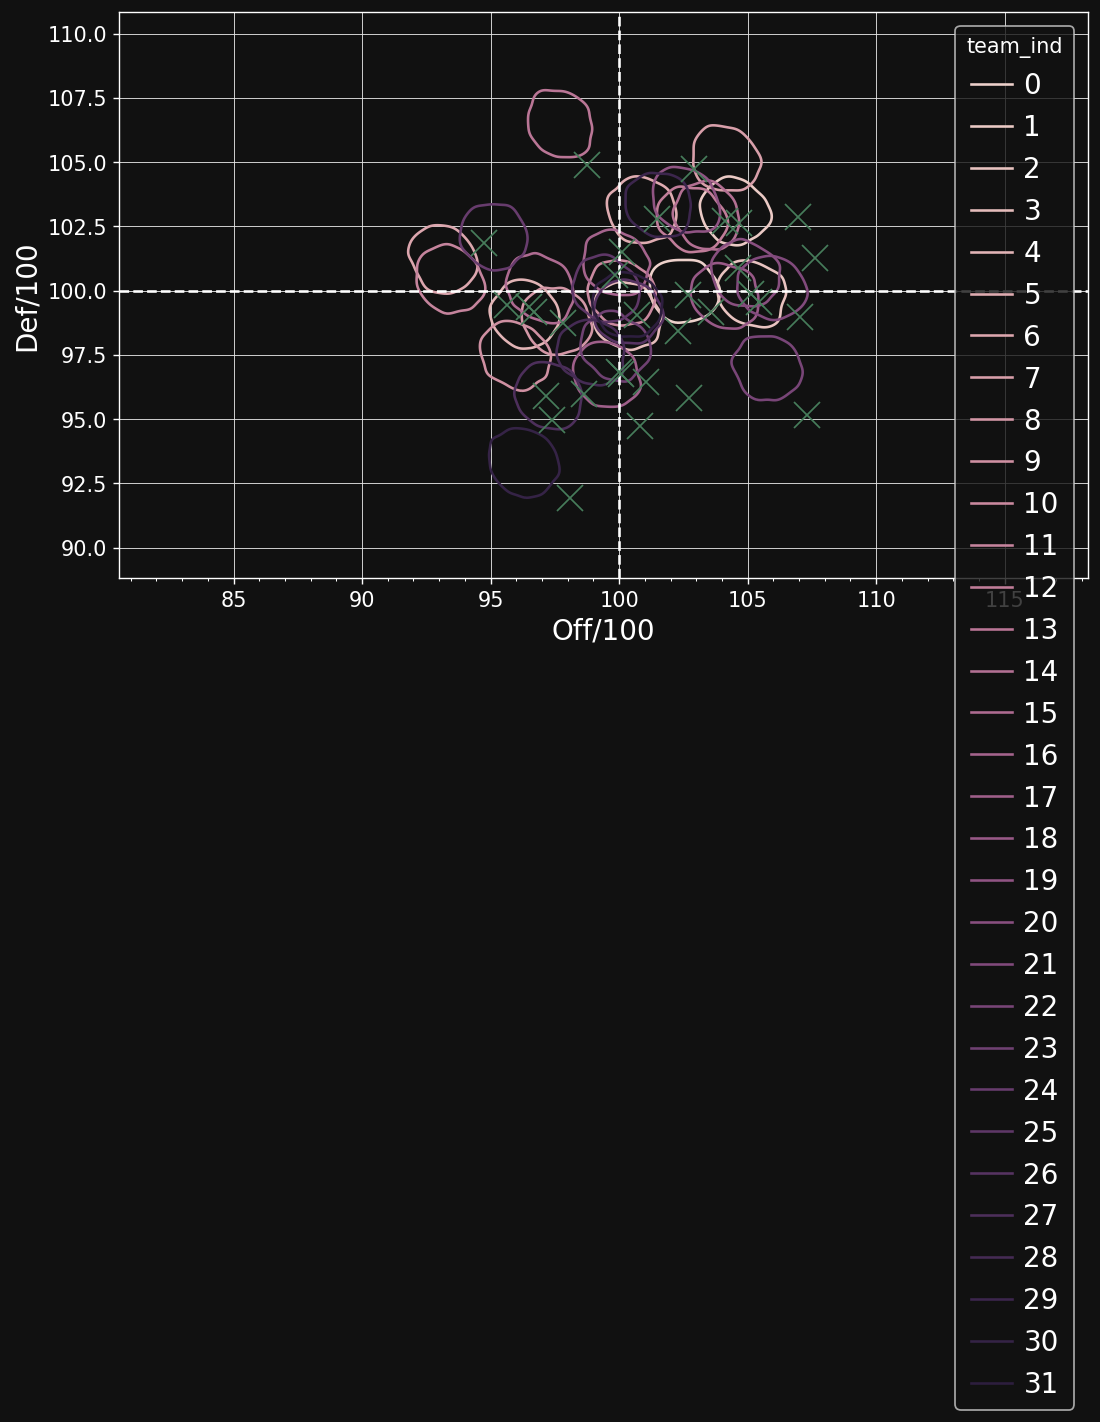

In [8]:
data = {}
data['team_off'] = (100 * trace['team_off'].dot(np.arange(4))).reshape(-1)
data['team_def'] = (100 * trace['team_def'].dot(np.arange(4))).reshape(-1)
data['team_ind'] = 8000 * [ind for ind in range(32)]
mdl_team_off = 100 * Model.teams_off.dot(np.arange(4).reshape(-1, 1))
mdl_team_def = 100 * Model.teams_def.dot(np.arange(4).reshape(-1, 1))
mu = Model.mu.dot(np.arange(4).reshape(-1, 1)).reshape(-1) * 100

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(mu, ls='--')
ax.axhline(mu, ls='--')
sns.kdeplot(data=data, x='team_off', y='team_def', hue='team_ind', levels=[0.5])
ax.axis('equal')
ax.set_xlabel('Off/100')
ax.set_ylabel('Def/100');

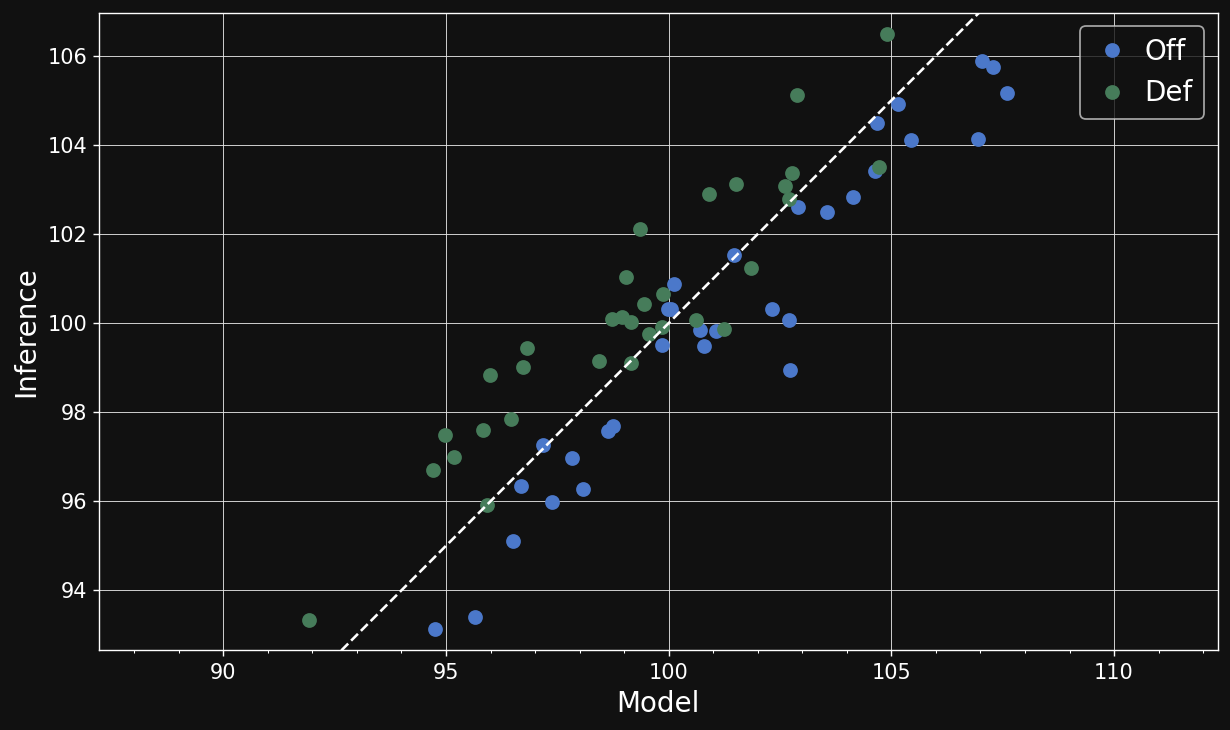

In [9]:
inf_team_off = 100 * trace['team_off'].mean(0).dot(np.arange(4).reshape(-1, 1))
mdl_team_off = 100 * Model.teams_off.dot(np.arange(4).reshape(-1, 1))
inf_team_def = 100 * trace['team_def'].mean(0).dot(np.arange(4).reshape(-1, 1))
mdl_team_def = 100 * Model.teams_def.dot(np.arange(4).reshape(-1, 1))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(mdl_team_off, inf_team_off, '.', ms=15, label='Off')
ax.plot(mdl_team_def, inf_team_def, '.', ms=15, label='Def')
ax.axline((100, 100), slope=1, ls='--', color='w')
ax.axis('equal')

ax.set_xlabel('Model')
ax.set_ylabel('Inference')
ax.legend();

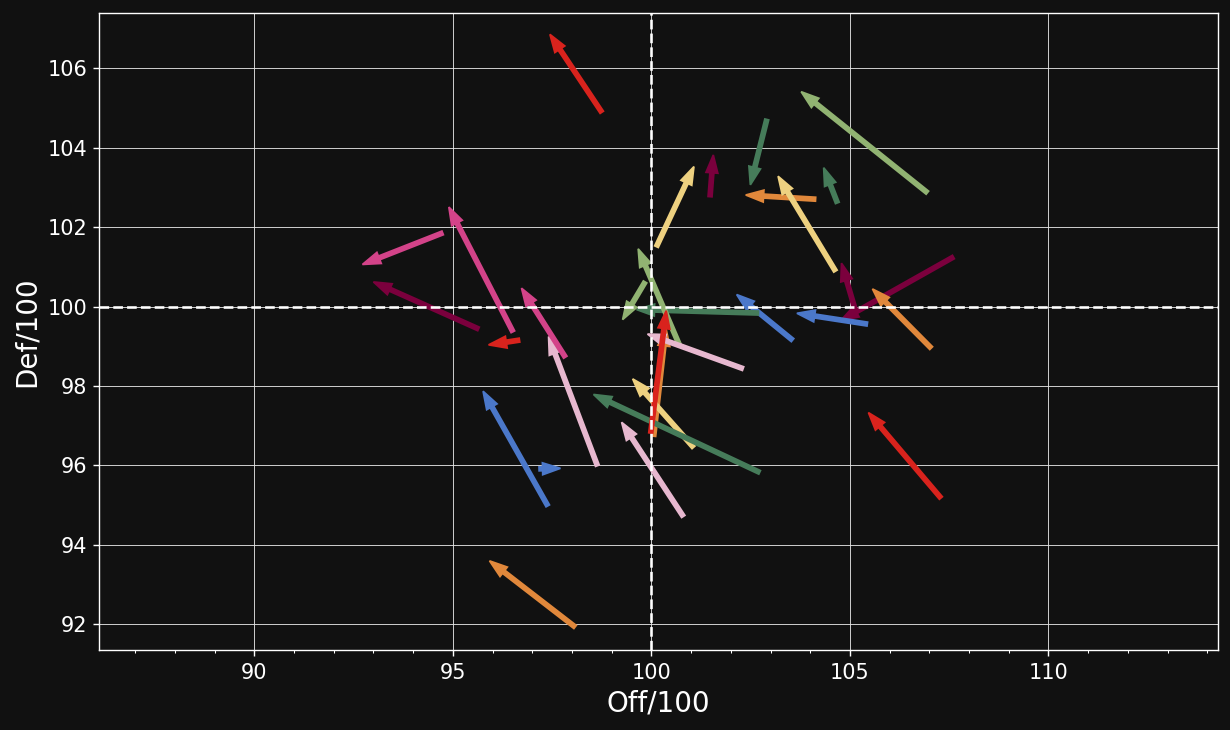

In [10]:
inf_teams_off = 100 * trace['team_off'].mean(0).dot(np.arange(4).reshape(-1, 1)).reshape(-1)
mdl_teams_off = 100 * Model.teams_off.dot(np.arange(4).reshape(-1, 1)).reshape(-1)
inf_teams_def = 100 * trace['team_def'].mean(0).dot(np.arange(4).reshape(-1, 1)).reshape(-1)
mdl_teams_def = 100 * Model.teams_def.dot(np.arange(4).reshape(-1, 1)).reshape(-1)
mu = Model.mu.dot(np.arange(4).reshape(-1, 1)).reshape(-1) * 100

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for ind, (inf_team_off, inf_team_def, mdl_team_off, mdl_team_def) in enumerate(zip(inf_teams_off, inf_teams_def, mdl_teams_off, mdl_teams_def)):
    ax.arrow(mdl_team_off, mdl_team_def, inf_team_off - mdl_team_off, inf_team_def - mdl_team_def, color=f'C{ind}', width=0.1)
ax.axvline(mu, ls='--')
ax.axhline(mu, ls='--')
ax.axis('equal')
ax.set_xlabel('Off/100')
ax.set_ylabel('Def/100');